In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [18]:
# 加载CSV数据
data = pd.read_csv('1_601360_klines.csv')

# 查看前几行数据
print(data.head())

    date_time  open  close  high   low  volume        value  amplitude  \
0  2023-01-03  6.44   6.64  6.65  6.40  395655  263973542.0       3.88   
1  2023-01-04  6.64   6.70  6.70  6.61  372649  251973075.0       1.36   
2  2023-01-05  6.70   6.68  6.71  6.65  210570  142793393.0       0.90   
3  2023-01-06  6.67   6.63  6.69  6.61  191053  128824252.0       1.20   
4  2023-01-09  6.63   6.65  6.71  6.63  176322  119216014.0       1.21   

   up_down_range  up_down_price  turnover_rate  
0           3.11           0.20           0.55  
1           0.90           0.06           0.52  
2          -0.30          -0.02           0.29  
3          -0.75          -0.05           0.27  
4           0.30           0.02           0.25  


In [19]:
# 选择收盘价 'close' 列作为预测目标
close_prices = data['close'].values
print(close_prices[:10])  # 打印前10个收盘价


[6.64 6.7  6.68 6.63 6.65 6.7  6.57 6.6  6.62 6.75]


In [20]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 创建 MinMaxScaler 实例，将数据归一化到 (0, 1) 之间
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices.reshape(-1, 1))

# 查看前几行归一化后的数据
print(close_prices_scaled[:10])


[[0.02556611]
 [0.02994887]
 [0.02848795]
 [0.02483565]
 [0.02629657]
 [0.02994887]
 [0.02045289]
 [0.02264427]
 [0.02410519]
 [0.03360117]]


In [21]:
# 设置时间步长，定义我们将使用多少天的历史数据来预测未来价格
n_steps = 20

# 创建输入序列X和目标序列y
X, y = [], []
for i in range(n_steps, len(close_prices_scaled)):
    X.append(close_prices_scaled[i-n_steps:i, 0])  # 前n步作为输入
    y.append(close_prices_scaled[i, 0])  # 第n+1步作为输出

# 转换为NumPy数组
X, y = np.array(X), np.array(y)

# 查看X和y的形状
print(X.shape, y.shape)


(395, 20) (395,)


In [22]:
# 重塑X为 (样本数, 时间步长, 特征数)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(X.shape)  # 查看形状


(395, 20, 1)


In [23]:
from sklearn.model_selection import train_test_split

# 将数据划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape, X_test.shape)


(316, 20, 1) (79, 20, 1)


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# 构建LSTM模型
model = Sequential()

# 使用Input显式定义输入层
model.add(Input(shape=(X_train.shape[1], 1)))

# 添加LSTM层
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # 添加Dropout防止过拟合

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=25))
model.add(Dense(units=1))

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 查看模型结构
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# 训练模型
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0607
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050
Epoch 16/50
10/10 ━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


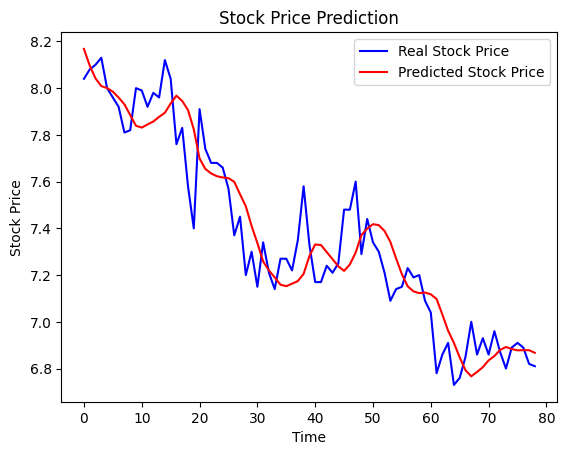

In [26]:
# 使用测试数据进行预测
predicted_prices = model.predict(X_test)

# 将预测值反归一化
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))

# 同样，反归一化实际的测试集价格
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# 绘制预测结果与实际结果对比
import matplotlib.pyplot as plt

plt.plot(real_prices, color='blue', label='Real Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [27]:
def predict_next_day(model, last_n_days):
    # 对最后n天的数据进行重塑为2D，然后归一化
    last_n_days = np.array(last_n_days).reshape(-1, 1)  # 重塑为二维数组
    last_n_days_scaled = scaler.transform(last_n_days)
    
    # 生成预测输入数据形状
    X_input = np.array([last_n_days_scaled])  # 扩展为三维数组
    X_input = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], 1))
    
    # 预测下一天的股价
    next_day_scaled = model.predict(X_input)
    
    # 反归一化，得到真实股价
    next_day_price = scaler.inverse_transform(next_day_scaled)
    return next_day_price


# 使用最后20天的真实收盘价预测下一天的价格
last_20_days = close_prices[-n_steps:]
predicted_next_day = predict_next_day(model, last_20_days)
print(f"Predicted next day price: {predicted_next_day[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted next day price: 6.849696636199951
